# SBU CSE 352 - HW 4 - Machine Learning From Scratch


All student names in group: Fia Hali, Andi Chen

I understand that my submission needs to be my own group's work: FH, AC

I understand that ChatGPT / Copilot / other AI tools are not allowed: FH, AC

---

## Instructions

Total Points: 100

1. Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Only use standard packages (numpy and built-in packages like random). Submit the completely rendered notebook as a HTML file.

  **Important:** Do not use scikit-learn or other packages with ML built in. The point of this is to be a learning exercise. Using linear algebra from numpy is okay (things like matrix operations or pseudoinverse, for example, but not lstsq).

2. Your notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use matplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
3. Document your code. Add a short discussion of how your implementation works and your design choices.

## Introduction

You will implement several machine learning algorithms and evaluate their accuracy. This will be done for a downscaled version of the MNIST digit recognition dataset.

**Like in real life, some of the tasks you will be asked to do may not be possible, at least directly. In these cases, your job is to figure out why it won't work and either propose a fix (best), or provide a clear explanation why it won't work.**

For example, if the problem says to do k-nearest neighbors with a dataset of a billion points, this could require too much time to do each classification so it's infeasible to evaluate its test accuracy. In this case, you could suggest randomly downsample the data to a more manageable size, which will speed things up by may lose some accuracy. In your answer, then, you should describe the problem and how you solved it and the trade-offs.

# Data
First the code below ensures you have access to the training data (a subset of the MNIST images), consisting of 100 handwritten images of each digit.

In [ ]:
# First download the repo and change the directory to be the one where the dependencies are.
# You should only need to do this once per session. If you want to reset, do Runtime -> Disconnect and Delete Runtime
# You can always do !pwd to see the current working directory and !ls to list current files.
!git clone https://github.com/stanleybak/CS7320-AI.git
%cd CS7320-AI/ML
!ls

Cloning into 'CS7320-AI'...
remote: Enumerating objects: 2738, done.
remote: Counting objects: 100% (855/855), done.
remote: Compressing objects: 100% (372/372), done.
remote: Total 2738 (delta 522), reused 796 (delta 478), pack-reused 1883
Receiving objects: 100% (2738/2738), 285.30 MiB | 16.78 MiB/s, done.
Resolving deltas: 100% (1690/1690), done.
Updating files: 100% (135/135), done.
/content/CS7320-AI/ML/CS7320-AI/ML/CS7320-AI/ML
line_fitting.ipynb	ML_example.ipynb	ML_for_tictactoe_self_play.ipynb  README.md
mini-mnist-1000.pickle	ML_for_tictactoe.ipynb	MNIST.ipynb


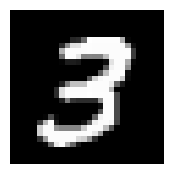

In [ ]:
import matplotlib.pyplot as plt
import pickle

# if the below fails to open, then the data file is not in the current working directory (see above code block)
with open('mini-mnist-1000.pickle', 'rb') as f:
  data = pickle.load(f)

im3 = data['images'][300] # 100 images of each digit
plt.figure(figsize=(2, 2))  # Adjust size as needed
plt.imshow(im3, cmap='gray')
plt.axis('off')
plt.show()

# Downscaling Images

MNIST images are originally 28x28. We will train our models not just on the original images, but also on downscaled images with the following sizes: 14x14, 7x7, 4x4, 2x2. The next code block shows one way to do downscaling. As you can tell from the output, we cannot expect our model's accuracy will be too high on lower resolution versions, although it's unclear how much better you can do than random chance, which should have a 10% accuracy.

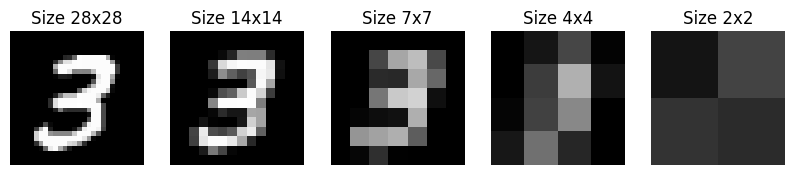

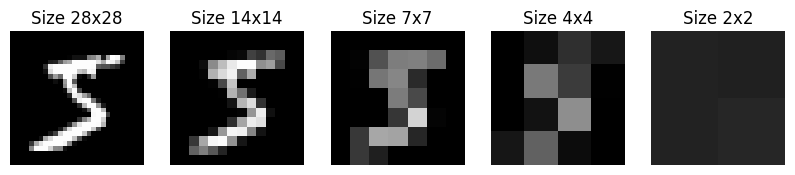

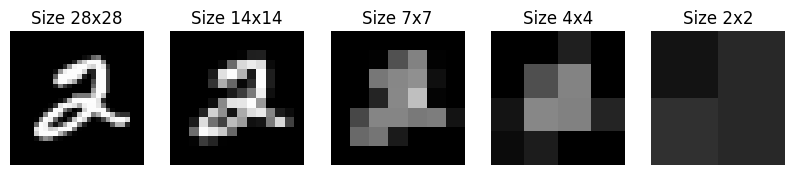

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Function to downscale an image to different sizes
def downscale_image(image, downscaled_size):
    block_size = 28 // downscaled_size
    downscaled = np.zeros((downscaled_size, downscaled_size))
    for i in range(downscaled_size):
        for j in range(downscaled_size):
            # Calculate the average for each block
            block = image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            downscaled[i, j] = np.mean(block)
    return downscaled

# Load the dataset (assuming this file is in your working directory)
with open('mini-mnist-1000.pickle', 'rb') as f:
    data = pickle.load(f)

images = data['images']  # a list of 1000 numpy image matrices
labels = data['labels']  # a list of 1000 integer labels

# Select 3 "random" indices from the dataset
random_indices = [300, 500, 200]

# Downscale the images to multiple sizes and display them
sizes = [28, 14, 7, 4, 2]
for index in random_indices:
    fig, axs = plt.subplots(1, len(sizes), figsize=(10, 2))
    for ax, size in zip(axs, sizes):
        downscaled_image = downscale_image(images[index], size)
        # print(downscaled_image)
        ax.imshow(downscaled_image, cmap='gray', vmin=0, vmax=255)
        ax.set_title(f'Size {size}x{size}')
        ax.axis('off')
    plt.show()

---
# Tasks

Your data contains 100 images in each class. When training models, use 80% of training, 10% for validation and 10% for testing. Make sure the data is balanced in each class when splitting.

---
## Task 1: Linear Classifier [20 points]

First, implement a linear classifier. The simplest way to do this is to adapt linear regression approaches that we learned about in class, where the output is a real number. For classification, we can let one category be an output of 1.0 and the other -1.0. Then, after the classifier is trained we can use the sign of the output to determine the predicted class.

However, since in MNIST there are multiple classes (10 digits, not just 2), we need to adapt the approach further. We will try both of the following two popular strategies: One-vs-Rest (OvR) and One-vs-One (OvO).

**One-vs-Rest (OvR)** is a strategy for using binary classification algorithms for multiclass problems. In this approach, a separate binary classifier is trained for each class, which predicts whether an instance belongs to that class or not, making it the 'one' against all other classes (the 'rest'). For a new input instance, compute the output of all classifiers. The predicted class is the one whose corresponding classifier gives the highest output value.

**One-vs-One (OvO)** is another strategy where a binary classifier is trained for every pair of classes. If there are N classes, you will train N(N−1)/2 classifiers. For a new input, evaluate it using all N(N−1)/2​ classifiers. Count the number of times each class is predicted over all binary classifications. The class with the highest count is selected as the final prediction.

### Report Results
Report the test accuracy for OvR and OvO, for each of the input image sizes, 28x28, 14x14, 7x7, 4x4, 2x2. A table may be helpful. Also report any interesting observations.

In [ ]:

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

# Function to downscale an image to different sizes
def downscale_image(image, downscaled_size):
    block_size = 28 // downscaled_size
    downscaled = np.zeros((downscaled_size, downscaled_size))
    for i in range(downscaled_size):
        for j in range(downscaled_size):
            # Calculate the average for each block
            block = image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            downscaled[i, j] = np.mean(block)
    return downscaled

# Load the dataset (assuming this file is in your working directory)
with open('mini-mnist-1000.pickle', 'rb') as f:
    data = pickle.load(f)

images = data['images']  # a list of 1000 numpy image matrices
labels = data['labels']  # a list of 1000 integer labels


def downscale_images(images, sizes=[28, 14, 7, 4, 2]):
    downscaled_images = {size: [] for size in sizes}
    for image in images:
        for size in sizes:
            downscaled = downscale_image(image, size)
            downscaled_images[size].append(downscaled.flatten())  # Flatten the image for perceptron
    return downscaled_images

def split_data(images, labels, train_ratio=0.8, val_ratio=0.1):
    indices = np.arange(len(images))
    np.random.shuffle(indices)

    train_end = int(len(indices) * train_ratio)
    val_end = train_end + int(len(indices) * val_ratio)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    return (images[train_indices], labels[train_indices]), (images[val_indices], labels[val_indices]), (images[test_indices], labels[test_indices])

# Perceptron and prediction functions
def train_perceptron(X, y, epochs=100, lr=0.01):
    weights = np.zeros(X.shape[1])
    bias = 0

    for epoch in range(epochs):
        for i in range(X.shape[0]):
            activation = np.dot(X[i], weights) + bias
            if y[i] * activation <= 0:
                weights += lr * y[i] * X[i]
                bias += lr * y[i]
    return weights, bias

def predict(weights, bias, X):
    return np.sign(np.dot(X, weights) + bias)

def accuracy(preds, labels):
    return np.mean(preds == labels)

# Classifier strategies
def one_vs_rest_classifier(X_train, y_train, X_test, y_test, num_classes=10):
    classifiers = []
    for class_ in range(num_classes):
        y_train_ovr = np.where(y_train == class_, 1, -1)
        weights, bias = train_perceptron(X_train, y_train_ovr)
        classifiers.append((weights, bias))

    predictions = np.array([predict(weights, bias, X_test) for weights, bias in classifiers])
    predictions = np.argmax(predictions, axis=0)
    return accuracy(predictions, y_test)

def one_vs_one_classifier(X_train, y_train, X_test, y_test, num_classes=10):
    from itertools import combinations
    classifiers = {}
    for class1, class2 in combinations(range(num_classes), 2):
        indices = np.where((y_train == class1) | (y_train == class2))
        X_train_ovo = X_train[indices]
        y_train_ovo = np.where(y_train[indices] == class1, 1, -1)
        weights, bias = train_perceptron(X_train_ovo, y_train_ovo)
        classifiers[(class1, class2)] = (weights, bias)

    votes = np.zeros((len(X_test), num_classes))
    for (class1, class2), (weights, bias) in classifiers.items():
        pred = predict(weights, bias, X_test)
        votes[:, class1] += (pred == 1)
        votes[:, class2] += (pred == -1)

    predictions = np.argmax(votes, axis=1)
    return accuracy(predictions, y_test)

# Process data and report results
downscaled_datasets = downscale_images(images)
results = {"Size": [], "OvR Accuracy": [], "OvO Accuracy": []}
sizes = [28, 14, 7, 4, 2]

for size in sizes:
    (images_train, labels_train), (_, _), (images_test, labels_test) = split_data(np.array(downscaled_datasets[size]), np.array(labels))
    ovr_acc = one_vs_rest_classifier(images_train, labels_train, images_test, labels_test)
    ovo_acc = one_vs_one_classifier(images_train, labels_train, images_test, labels_test)

    results["Size"].append(f"{size}x{size}")
    results["OvR Accuracy"].append(f"{ovr_acc * 100:.2f}%")
    results["OvO Accuracy"].append(f"{ovo_acc * 100:.2f}%")

results_df = pd.DataFrame(results)
print(results_df)

    Size OvR Accuracy OvO Accuracy
0  28x28       69.00%       82.00%
1  14x14       79.00%       85.00%
2    7x7       68.00%       81.00%
3    4x4       43.00%       71.00%
4    2x2       24.00%       25.00%


---
## Task 2: Data Augmentation [20 points]

Your boss was unhappy with the test accuracy, especially of your 2x2 image classifier, and has made some suggestions. The problem, according to your boss, is that there is not enough data in each input $x$. You are told to augment the data with derived features in order to help the classifier.

Specifically, given an input $x$, create additional attributes by computing all of the data up to powers of two. For example, in the 2x2 case your example $x$ consists of four pixel values $x_0$, $x_1$, $x_2$, and $x_3$. Your new input data would have:

* all power of zero: 1 (constant)
* all powers of one: $x_0$, $x_1$, $x_2$, $x_3$
* all powers of two:

  $x_0^2$, $x_0 x_1$, $x_0 x_2$, $x_0 x_3$,
  
  $x_1^2$, $x_1 x_2$, $ x_1 x_3$,
  
  $x_2^2$, $x_2 x_3$,
  
  $x_3^2$

The data would have 15 values, which has the potential to learn nonlinear relationships between the original inputs, which was not possible before.

### Report Results

Report the test accuracy for OvR only, with the data augmentation approach, for each of the input image sizes, 28x28, 14x14, 7x7, 4x4, 2x2 (again, perhaps incorporating a table). Report any interesting results or observations.

Also, explain to your boss what the danger is of looking at a model's final test accuracy and then suggesting changes to improve it. What should be done instead, if you know you will consider different types of models or hyperparameters in the same model class?

In [ ]:
import numpy as np
from itertools import combinations_with_replacement

def augment_data(X):
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    num_features = X.shape[1]
    augmented_features = [np.ones((X.shape[0], 1))]

    # Add all powers of one
    augmented_features.append(X)

    # Add all powers of two
    for indices in combinations_with_replacement(range(num_features), 2):
        augmented_feature = np.prod(X[:, indices], axis=1).reshape(-1, 1)
        augmented_features.append(augmented_feature)

    return np.hstack(augmented_features)

sizes = [28, 14, 7, 4, 2]
results = {"Size": [], "OvR Accuracy": []}
for size in sizes:
    augmented_X_train=[]
    augmented_X_test=[]
    (images_train, labels_train), (_, _), (images_test, labels_test) = split_data(np.array(downscaled_datasets[size]), np.array(labels))
    for x in images_train:
      augmented_X_train.append(augment_data(x))
    for x in images_test:
      augmented_X_test.append(augment_data(x))
    ovr_acc = one_vs_rest_classifier(images_train, labels_train, images_test, labels_test)

    results["Size"].append(f"{size}x{size}")
    results["OvR Accuracy"].append(f"{ovr_acc * 100:.2f}%")

results_df = pd.DataFrame(results)
print(results_df)


    Size OvR Accuracy
0  28x28       80.00%
1  14x14       75.00%
2    7x7       65.00%
3    4x4       45.00%
4    2x2       13.00%


In [ ]:
# it is important to undertand the test accuracy is just one performance metrics of the model.
#  when improving the model after geting the result will limit ourselves on this specifit data,
# and when the same model is used for other data, the test accuracy might change and bring us wrong predictions.


---
## Task 3: k-Nearest Neighbors Classifier [20 points]

Your boss is still unhappy with the results (and still ignoring your advice about not using test data accuracy for model decisions).

Next, you are to use the k-nearest neighbors approach to build a classifier for our data. Since we have multiple classes, the one that gets selected can be based on a plurality vote of the $k$ closest samples (whichever category is most frequent). If there are ties, select the class based on the sum of the distances from the test point. For example, if $k=5$, and the closest 5 samples have two pictures that are from category "1" and two pictures that are from category "7", then you choose the output by computing the sum of the distance from the test point and the two "5" samples, as well as the sum of distances from the test point to the two "7" samples, and then outputting the class with the smaller total distance.

### Report Results

For each image size, exhaustively explore different values of $k$ up to 50. Report the best test accuracy. Report the average time taken to do a lookup with the model.

In [ ]:
import numpy as np
import time

# Define function to calculate Euclidean distance between two points
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

# Define KNN classifier function
def knn_classifier(X_train, y_train, X_test, k):
    predictions = []
    for test_point in X_test:
        distances = [euclidean_distance(test_point, train_point) for train_point in X_train]
        nearest_indices = np.argsort(distances)[:k]
        y_train = np.array(y_train)
        nearest_labels = y_train[nearest_indices]
        unique_labels, label_counts = np.unique(nearest_labels, return_counts=True)
        majority_label = unique_labels[np.argmax(label_counts)]
        predictions.append(majority_label)
    return predictions

best_test_accuracy = {}

sizes = [28, 14, 7, 4, 2]
for size in sizes:
    test_accuracies = {}

    # Loop over different k values from 1 to 50
    for k in range(1, 51):
        start_time = time.time()
        y_pred = knn_classifier(images_train, labels_train, images_test, k)
        lookup_time = (time.time() - start_time) / len(images_test)

        # Evaluate accuracy of predictions
        test_accuracy = np.mean(y_pred == labels_test)
        test_accuracies[k] = test_accuracy

    # Find the k value with the best test accuracy
    best_k = max(test_accuracies, key=test_accuracies.get)
    best_test_accuracy[size] = (best_k, test_accuracies[best_k])

for image_size, (best_k, best_accuracy) in best_test_accuracy.items():
    print(f"Best test accuracy for image size {image_size}x{image_size}:")
    print(f"- k = {best_k}, Test Accuracy = {best_accuracy:.4f}")


Best test accuracy for image size 28x28:
- k = 5, Test Accuracy = 0.4800
Best test accuracy for image size 14x14:
- k = 5, Test Accuracy = 0.4800
Best test accuracy for image size 7x7:
- k = 5, Test Accuracy = 0.4800
Best test accuracy for image size 4x4:
- k = 5, Test Accuracy = 0.4800
Best test accuracy for image size 2x2:
- k = 5, Test Accuracy = 0.4800


---
## Task 4: Neural Networks [40 Points]

Next, your boss wants you to try neural networks. Rather than using a library for everything, you will **only** use `pytorch` to perform backpropagation and compute gradients. You can write your own neural network class if desired, don't use anything from `pytorch` for that.


An example network and how to compute gradients with pytorch is shown below.


In [ ]:
# Example of using pytorch to compute gradients and updates weights and biases
#
# The network consists of:
# 1. An input layer with 3 features.
# 2. A first hidden layer with 3 neurons. Each neuron in this layer performs a linear transformation
#    on the input data using a weight matrix (W1) and a bias vector (b1). This is followed by a sigmoid
#    activation function.
# 3. A second hidden layer, also with 3 neurons, which processes the output of the first layer. Similar
#    to the first layer, it uses a weight matrix (W2) and a bias vector (b2) for linear transformation,
#    followed by a softmax activation function. The softmax activation is used here to normalize the
#    output of the second layer into a probability distribution over the three classes. This is particularly
#    useful for multi-class classification problems.
# 4. The network uses cross-entropy as the loss function, which is a common choice for classification tasks
#    involving softmax outputs. This loss function compares the predicted probability distribution with the
#    true distribution (one-hot encoded) and penalizes the predictions that diverge from the actual labels.
#


import torch

# Initialize input, weights, and biases
x = torch.tensor([1.0, 2.0, 3.0])
W1 = torch.tensor([[0.1, 0.2, 0.5],
                  [-0.1, -0.5, -1.1],
                  [0, 7.5, -1.1]], requires_grad=True)
b1 = torch.tensor([0.0, 0.0, 0.0], requires_grad=True)

W2 = torch.tensor([[0.1, -0.3, 0.4],
                  [0.2, 0.4, -0.6],
                  [-0.1, 0.5, -0.2]], requires_grad=True)
b2 = torch.tensor([0.0, 0.0, 0.0], requires_grad=True)

# Target output
y_true = torch.tensor([1.0, 0.0, 0.0])

# Forward pass through first layer
z1 = torch.matmul(W1, x) + b1
a1 = torch.sigmoid(z1)  # Sigmoid activation

# Forward pass through second layer
z2 = torch.matmul(W2, a1) + b2
a2 = torch.softmax(z2, dim=0)  # Softmax activation

print("Initial Output:", a2)
print("Desired Output:", y_true)

# Compute loss (Cross-entropy): https://en.wikipedia.org/wiki/Cross-entropy
loss = -torch.sum(y_true * torch.log(a2))
print("Initial loss:", loss.item())

# Backpropagation
loss.backward()

# you can print out gradient for each element now
print("Gradient for weights matrix W1:", W1.grad)

# Update weights and biases based on gradient (should reduce loss)
learning_rate = 0.02

# the no_grad() environment is needed to indicate that the computation should not
# be part of the gradient computation
with torch.no_grad():
    W1 -= learning_rate * W1.grad
    b1 -= learning_rate * b1.grad
    W2 -= learning_rate * W2.grad
    b2 -= learning_rate * b2.grad

# After the update, clear the gradients (in case we want to compute them again later)
W1.grad.zero_()
b1.grad.zero_()
W2.grad.zero_()
b2.grad.zero_()

# Forward pass with updated weights and biases
z1 = torch.matmul(W1, x) + b1
a1 = torch.sigmoid(z1)  # Sigmoid activation
z2 = torch.matmul(W2, a1) + b2
a2 = torch.softmax(z2, dim=0)  # Softmax activation

# Compute new loss
new_loss = -torch.sum(y_true * torch.log(a2))
print("New loss after updating weights and biases:", new_loss.item())


Initial Output: tensor([0.5348, 0.2167, 0.2485], grad_fn=<SoftmaxBackward0>)
Desired Output: tensor([1., 0., 0.])
Initial loss: 0.625852644443512
Gradient for weights matrix W1: tensor([[-2.9431e-03, -5.8862e-03, -8.8293e-03],
        [ 4.1993e-03,  8.3986e-03,  1.2598e-02],
        [-3.0524e-06, -6.1048e-06, -9.1572e-06]])
New loss after updating weights and biases: 0.6079817414283752


The code above updates the parameters based on a single piece of data, but often multiple inputs are used and their gradient is averaged when updating a model.

Your task is to write the training code for the different neural network architectures proposed and report accuracy. Start with all random parameters between -1 and 1. Training should stop when the accuracy, as measured on the validation data, no longer appears to be improving. You can plot the validation data accuracy over time to ensure this looks correct. If this takes too long but it appears the model is still improving in accuracy, consider increasing the learning rate (start with 0.02 as in the example).

For the gradient, you are to compute the gradient over the full set of training data, and then average them together before you update. Then, repeat with mini-batches of size 100, with 10 random samples from each class. This should update the model weights faster, but may require more updates to get the accuracy down.

### Report Results

Provide at least one plot of your validation data accuracy going down over time as training progresses. What was the condition you decided to use to detect if training should stop? How many updates were needed in the case of your plot?


Create a table where each row corresponds to one model and training method (mini-batch or full). Use the 7x7 version of the data (49-dimensional inputs). You are to explore the following models: the number of hidden layers can be varied between 2 and 4. Each layer's size can be 16, 32, or 64 neurons (all hidden layers have the same number of neurons). Explore three different activation functions for the network, ReLU (`torch.relu`), arctan (`torch.atan`), and sigmoid (`torch.sigmoid`). After the final layer, use a softmax rather than the normal network activation function, to ensure all outputs are between 0 and 1. There should be 10 outputs, one for each class in the MNIST data.

In the table, report the architecture, training time, number of model updates and test accuracy. What is the best architecture? Did mini-batches help with anything? Report any other interesting observations.



Initial Output: tensor([0.5348, 0.2167, 0.2485], grad_fn=<SoftmaxBackward0>)
Desired Output: tensor([1., 0., 0.])
Initial loss: 0.625852644443512
Gradient for weights matrix W1: tensor([[-2.9431e-03, -5.8862e-03, -8.8293e-03],
        [ 4.1993e-03,  8.3986e-03,  1.2598e-02],
        [-3.0524e-06, -6.1048e-06, -9.1572e-06]])
New loss after updating weights and biases: 0.6079817414283752
Epoch 1: Loss = 2.3278, Validation Accuracy = 10.50%
Epoch 2: Loss = 2.3057, Validation Accuracy = 10.00%
Epoch 3: Loss = 2.3001, Validation Accuracy = 10.50%
Epoch 4: Loss = 2.2993, Validation Accuracy = 10.50%
Epoch 5: Loss = 2.2981, Validation Accuracy = 10.50%
Epoch 6: Loss = 2.2976, Validation Accuracy = 10.50%
Early stopping after 6 epochs due to no improvement in validation accuracy.


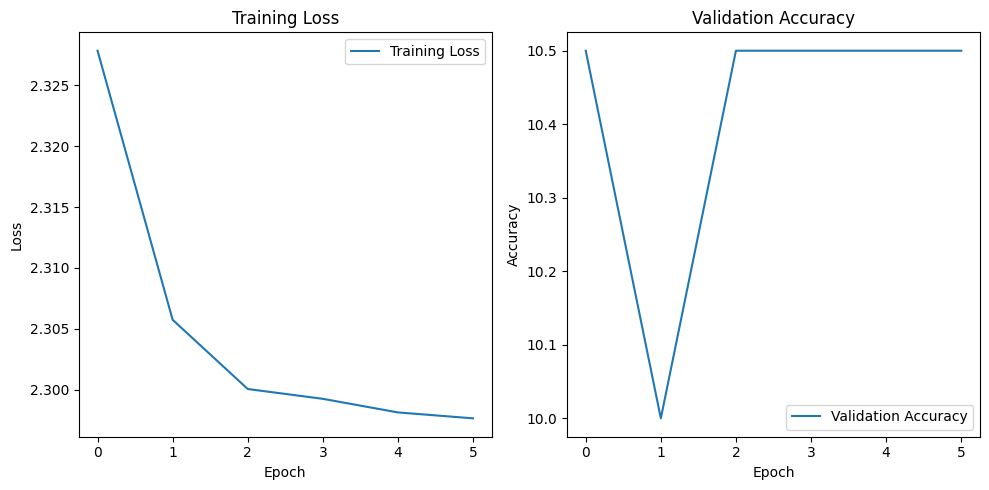

                              Architecture  Training Time  Updates  \
0      2 layers of 16 units each with ReLU       1.337737      500   
1    2 layers of 16 units each with arctan       0.907978      500   
2   2 layers of 16 units each with sigmoid       0.876330      500   
3      2 layers of 32 units each with ReLU       0.887227      500   
4    2 layers of 32 units each with arctan       0.927863      500   
5   2 layers of 32 units each with sigmoid       0.875158      500   
6      2 layers of 64 units each with ReLU       0.922402      500   
7    2 layers of 64 units each with arctan       1.178171      500   
8   2 layers of 64 units each with sigmoid       0.909454      500   
9      3 layers of 16 units each with ReLU       0.918359      500   
10   3 layers of 16 units each with arctan       0.968592      500   
11  3 layers of 16 units each with sigmoid       1.177408      500   
12     3 layers of 32 units each with ReLU       1.454796      500   
13   3 layers of 32 

In [ ]:
# Example of using pytorch to compute gradients and updates weights and biases
#
# The network consists of:
# 1. An input layer with 3 features.
# 2. A first hidden layer with 3 neurons. Each neuron in this layer performs a linear transformation
#    on the input data using a weight matrix (W1) and a bias vector (b1). This is followed by a sigmoid
#    activation function.
# 3. A second hidden layer, also with 3 neurons, which processes the output of the first layer. Similar
#    to the first layer, it uses a weight matrix (W2) and a bias vector (b2) for linear transformation,
#    followed by a softmax activation function. The softmax activation is used here to normalize the
#    output of the second layer into a probability distribution over the three classes. This is particularly
#    useful for multi-class classification problems.
# 4. The network uses cross-entropy as the loss function, which is a common choice for classification tasks
#    involving softmax outputs. This loss function compares the predicted probability distribution with the
#    true distribution (one-hot encoded) and penalizes the predictions that diverge from the actual labels.
#


import torch

# Initialize input, weights, and biases
x = torch.tensor([1.0, 2.0, 3.0])
W1 = torch.tensor([[0.1, 0.2, 0.5],
                  [-0.1, -0.5, -1.1],
                  [0, 7.5, -1.1]], requires_grad=True)
b1 = torch.tensor([0.0, 0.0, 0.0], requires_grad=True)

W2 = torch.tensor([[0.1, -0.3, 0.4],
                  [0.2, 0.4, -0.6],
                  [-0.1, 0.5, -0.2]], requires_grad=True)
b2 = torch.tensor([0.0, 0.0, 0.0], requires_grad=True)

# Target output
y_true = torch.tensor([1.0, 0.0, 0.0])

# Forward pass through first layer
z1 = torch.matmul(W1, x) + b1
a1 = torch.sigmoid(z1)  # Sigmoid activation

# Forward pass through second layer
z2 = torch.matmul(W2, a1) + b2
a2 = torch.softmax(z2, dim=0)  # Softmax activation

print("Initial Output:", a2)
print("Desired Output:", y_true)

# Compute loss (Cross-entropy): https://en.wikipedia.org/wiki/Cross-entropy
loss = -torch.sum(y_true * torch.log(a2))
print("Initial loss:", loss.item())

# Backpropagation
loss.backward()

# you can print out gradient for each element now
print("Gradient for weights matrix W1:", W1.grad)

# Update weights and biases based on gradient (should reduce loss)
learning_rate = 0.02

# the no_grad() environment is needed to indicate that the computation should not
# be part of the gradient computation
with torch.no_grad():
    W1 -= learning_rate * W1.grad
    b1 -= learning_rate * b1.grad
    W2 -= learning_rate * W2.grad
    b2 -= learning_rate * b2.grad

# After the update, clear the gradients (in case we want to compute them again later)
W1.grad.zero_()
b1.grad.zero_()
W2.grad.zero_()
b2.grad.zero_()

# Forward pass with updated weights and biases
z1 = torch.matmul(W1, x) + b1
a1 = torch.sigmoid(z1)  # Sigmoid activation
z2 = torch.matmul(W2, a1) + b2
a2 = torch.softmax(z2, dim=0)  # Softmax activation

# Compute new loss
new_loss = -torch.sum(y_true * torch.log(a2))
print("New loss after updating weights and biases:", new_loss.item())

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.sigmoid(self.layer1(x))
        x = F.sigmoid(self.layer2(x))
        x = self.layer3(x)  # Output raw logits
        return x

def validate(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def train_network(model, train_loader, valid_loader, epochs, learning_rate, patience):
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    train_losses = []
    val_accuracies = []
    best_val_acc = 0
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        total_loss = 0
        num_batches = 0

        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = loss_fn(output, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num_batches += 1

        avg_loss = total_loss / num_batches
        train_losses.append(avg_loss)
        val_acc = validate(model, valid_loader)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch + 1}: Loss = {avg_loss:.4f}, Validation Accuracy = {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f"Early stopping after {epoch+1} epochs due to no improvement in validation accuracy.")
            break

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example placeholders for data loading, replace with actual data loading
X_train_tensor = torch.randn(1000, 784)  # Example random data
y_train_tensor = torch.randint(0, 10, (1000,))  # Example random labels
X_val_tensor = torch.randn(200, 784)  # Example random validation data
y_val_tensor = torch.randint(0, 10, (200,))  # Example random validation labels

train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_data, batch_size=100, shuffle=False)

model = SimpleNN(784, 128, 10)
train_network(model, train_loader, val_loader, 50, 0.02, 5)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from time import time
import pandas as pd

# Define the flexible neural network class
class FlexibleNN(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_size, output_size, activation_fn):
        super(FlexibleNN, self).__init__()
        self.layers = nn.ModuleList()
        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_size))
        # Additional hidden layers
        for _ in range(hidden_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        # Output layer
        self.layers.append(nn.Linear(hidden_size, output_size))
        self.activation_fn = activation_fn

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation_fn(layer(x))
        x = F.softmax(self.layers[-1](x), dim=1)
        return x

# Train and evaluate function
def train_and_evaluate(model, train_loader, valid_loader, epochs, learning_rate):
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    start_time = time()
    updates = 0

    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            updates += 1

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    training_time = time() - start_time
    return training_time, updates, accuracy

# Example data loading and preprocessing (replace with actual MNIST data loading and resizing to 7x7)
# Dummy data for illustration:
train_inputs = torch.randn(1000, 49)  # Random features for training
train_labels = torch.randint(0, 10, (1000,))  # Random labels for training
valid_inputs = torch.randn(200, 49)  # Random features for validation
valid_labels = torch.randint(0, 10, (200,))  # Random labels for validation

train_data = TensorDataset(train_inputs, train_labels)
valid_data = TensorDataset(valid_inputs, valid_labels)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=100, shuffle=False)

# Configuration settings
hidden_layers_options = [2, 3, 4]
hidden_sizes_options = [16, 32, 64]
activation_functions = {
    'ReLU': torch.relu,
    'arctan': torch.atan,
    'sigmoid': torch.sigmoid
}

# Results storage
results = []

# Running the experiments
for layers in hidden_layers_options:
    for size in hidden_sizes_options:
        for name, activation_fn in activation_functions.items():
            model = FlexibleNN(49, layers, size, 10, activation_fn)
            training_time, updates, accuracy = train_and_evaluate(model, train_loader, valid_loader, 50, 0.01)
            results.append({
                'Architecture': f'{layers} layers of {size} units each with {name}',
                'Training Time': training_time,
                'Updates': updates,
                'Test Accuracy': f'{accuracy:.2f}%'
            })

# Displaying results in a DataFrame
results_df = pd.DataFrame(results)
print(results_df)
